In [1]:
# 03 – Feature Analysis and Selection

# This notebook explores candidate input features for predicting SPP and annular pressure
# in normal drilling conditions. We analyze correlations, missingness, stability across
# wells, and propose a base feature set for ML models.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")


In [3]:
# Column name constants (matching actual data column names)
DEPTH_COL = "Depth(m)"
TVD_COL = "TVD(m)"
SPP_COL = "SPP Avg(bar)"
ANNULAR_COL = "Annular Press(barg)"
FLOW_COL = "Flow In Pum Avg(lpm)"
ROP_COL = "ROP Avg(m/hr)"
TORQUE_COL = "Torque Abs Avg(kN-m)"
WOB_COL = "WOB Avg(mton)"
RPM_COL = "RPM Surface Avg(rpm)"
MUD_DENSITY_COL = "Dens Mud(sg)"

# Candidate input features (excluding targets and derived ratios)
BASE_FEATURE_CANDIDATES = [
    DEPTH_COL,
    TVD_COL,
    FLOW_COL,
    ROP_COL,
    TORQUE_COL,
    WOB_COL,
    RPM_COL,
    MUD_DENSITY_COL,
]

# Additional engineered features (derived from allowed inputs)
ENGINEERED_FEATURES = [
    "mass_flow",          # Flow * Mud density
    "depth_normalized",   # Depth relative to min depth per well (m from top)
    "depth_rel",          # Depth normalized 0-1 within each well
    "inclination_proxy",  # |Depth - TVD|
    "dWOB_dmd",           # First difference of WOB (per meter)
    "dFlow_dmd",          # First difference of Flow (per meter)
    "dROP_dmd",           # First difference of ROP (per meter)
    "WOB_mean_10m",       # Rolling mean of WOB over ~10 m
    "Flow_mean_10m",      # Rolling mean of Flow over ~10 m
    "torque_per_rpm",     # Torque / RPM
    "rop_per_rpm",        # ROP / RPM
]

ALL_FEATURE_COLS = BASE_FEATURE_CANDIDATES + ENGINEERED_FEATURES


In [4]:
# Load processed dataset
data_path = Path("../data/all_wells_processed.parquet")
df = pd.read_parquet(data_path)

print(f"Loaded dataset: {len(df)} rows, {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nBasic info:")
print(df.info())
print(f"\nFirst few rows:")
print(df.head())
print(f"\nNumeric columns summary:")
print(df.select_dtypes(include=[np.number]).describe())

# Assert expected columns exist
required_cols = [DEPTH_COL, TVD_COL, SPP_COL, FLOW_COL, ROP_COL, TORQUE_COL, 
                 WOB_COL, RPM_COL, MUD_DENSITY_COL, ANNULAR_COL, "well_id", "mode"]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"\n✓ All required columns present")
print(f"\nWells: {df['well_id'].unique()}")
print(f"\nModes: {df['mode'].unique()}")


Loaded dataset: 11442 rows, 18 columns

Columns: ['Depth(m)', 'TVD(m)', 'SPP Avg(bar)', 'Flow In Pum Avg(lpm)', 'ROP Avg(m/hr)', 'Torque Abs Avg(kN-m)', 'WOB Avg(mton)', 'RPM Surface Avg(rpm)', 'Dens Mud(sg)', 'Annular Press(barg)', 'well_id', 'SPP_smooth', 'SPP_ratio', 'AP_smooth', 'AP_ratio', 'mode', 'distance_to_low_pressure_m', 'is_core_drill']

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11442 entries, 0 to 11441
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Depth(m)                    11442 non-null  float64 
 1   TVD(m)                      10989 non-null  float64 
 2   SPP Avg(bar)                11437 non-null  float64 
 3   Flow In Pum Avg(lpm)        11437 non-null  float64 
 4   ROP Avg(m/hr)               11436 non-null  float64 
 5   Torque Abs Avg(kN-m)        11437 non-null  float64 
 6   WOB Avg(mton)               11437 non-null  float64 
 7   

In [5]:
# Filter to normal drilling samples
df_drill = df[df["mode"] == "drill"].copy()
print(f"Drill mode samples: {len(df_drill)} (from {len(df)} total)")

# Drop rows where SPP is NaN (cannot use for SPP modeling)
df_drill = df_drill[df_drill[SPP_COL].notna()].copy()
print(f"After dropping NaN SPP: {len(df_drill)} samples")

# Check annular pressure availability
annular_available = df_drill[ANNULAR_COL].notna().sum()
print(f"\nAnnular pressure available: {annular_available} / {len(df_drill)} samples ({100*annular_available/len(df_drill):.1f}%)")
print(f"Annular pressure by well:")
print(df_drill.groupby("well_id")[ANNULAR_COL].apply(lambda x: f"{x.notna().sum()}/{len(x)} ({100*x.notna().sum()/len(x):.1f}%)"))

# ------------------------------------------------------------------
# Feature engineering (computed once, reused later)
# ------------------------------------------------------------------

# Mass flow = flow rate * mud density
df_drill["mass_flow"] = df_drill[FLOW_COL] * df_drill[MUD_DENSITY_COL]

# Depth normalized per well (depth from start of section)
df_drill["depth_normalized"] = df_drill.groupby("well_id")[DEPTH_COL].transform(lambda x: x - x.min())

# Depth relative (0-1) within each well
def _depth_rel(series: pd.Series) -> pd.Series:
    span = series.max() - series.min()
    if span == 0:
        return pd.Series(0.0, index=series.index)
    return (series - series.min()) / span

df_drill["depth_rel"] = df_drill.groupby("well_id")[DEPTH_COL].transform(_depth_rel)

# Inclination proxy: |Depth - TVD|
df_drill["inclination_proxy"] = (df_drill[DEPTH_COL] - df_drill[TVD_COL]).abs()

# First differences per well (aligned with depth order)
df_drill = df_drill.sort_values(["well_id", DEPTH_COL]).reset_index(drop=True)
df_drill["dWOB_dmd"] = df_drill.groupby("well_id")[WOB_COL].diff()
df_drill["dFlow_dmd"] = df_drill.groupby("well_id")[FLOW_COL].diff()
df_drill["dROP_dmd"] = df_drill.groupby("well_id")[ROP_COL].diff()

# Rolling means over ~10 meters (10 samples)
def _rolling_mean_by_well(df_subset: pd.DataFrame, col: str, window: int = 10) -> pd.Series:
    return (
        df_subset
        .sort_values(DEPTH_COL)
        .groupby("well_id")[col]
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

df_drill["WOB_mean_10m"] = _rolling_mean_by_well(df_drill, WOB_COL, window=10)
df_drill["Flow_mean_10m"] = _rolling_mean_by_well(df_drill, FLOW_COL, window=10)

# Ratios
with np.errstate(divide="ignore", invalid="ignore"):
    df_drill["torque_per_rpm"] = df_drill[TORQUE_COL] / df_drill[RPM_COL]
    df_drill["rop_per_rpm"] = df_drill[ROP_COL] / df_drill[RPM_COL]

df_drill.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nEngineered features added:")
print(ENGINEERED_FEATURES)


Drill mode samples: 8913 (from 11442 total)
After dropping NaN SPP: 8913 samples

Annular pressure available: 8913 / 8913 samples (100.0%)
Annular pressure by well:
well_id
A    2496/2496 (100.0%)
B      523/523 (100.0%)
C    1762/1762 (100.0%)
D    4132/4132 (100.0%)
Name: Annular Press(barg), dtype: object

Engineered features added:
['mass_flow', 'depth_normalized', 'depth_rel', 'inclination_proxy', 'dWOB_dmd', 'dFlow_dmd', 'dROP_dmd', 'WOB_mean_10m', 'Flow_mean_10m', 'torque_per_rpm', 'rop_per_rpm']


Full correlation matrix (features + targets):


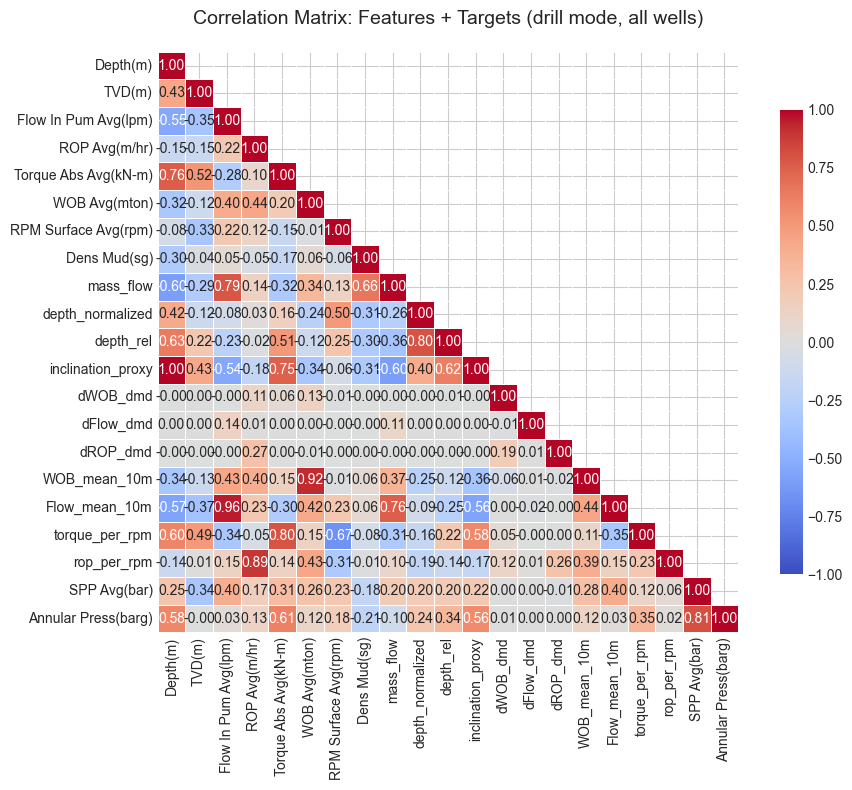


Correlations with SPP:
             feature  corr_with_SPP
       Flow_mean_10m       0.401417
Flow In Pum Avg(lpm)       0.395710
              TVD(m)      -0.341258
Torque Abs Avg(kN-m)       0.310259
        WOB_mean_10m       0.276579
       WOB Avg(mton)       0.260581
            Depth(m)       0.245531
RPM Surface Avg(rpm)       0.227826
   inclination_proxy       0.217421
    depth_normalized       0.204731
           depth_rel       0.202156
           mass_flow       0.196467
        Dens Mud(sg)      -0.177057
       ROP Avg(m/hr)       0.171205
      torque_per_rpm       0.116947
         rop_per_rpm       0.057431
            dROP_dmd      -0.008107
           dFlow_dmd       0.003318
            dWOB_dmd       0.002902


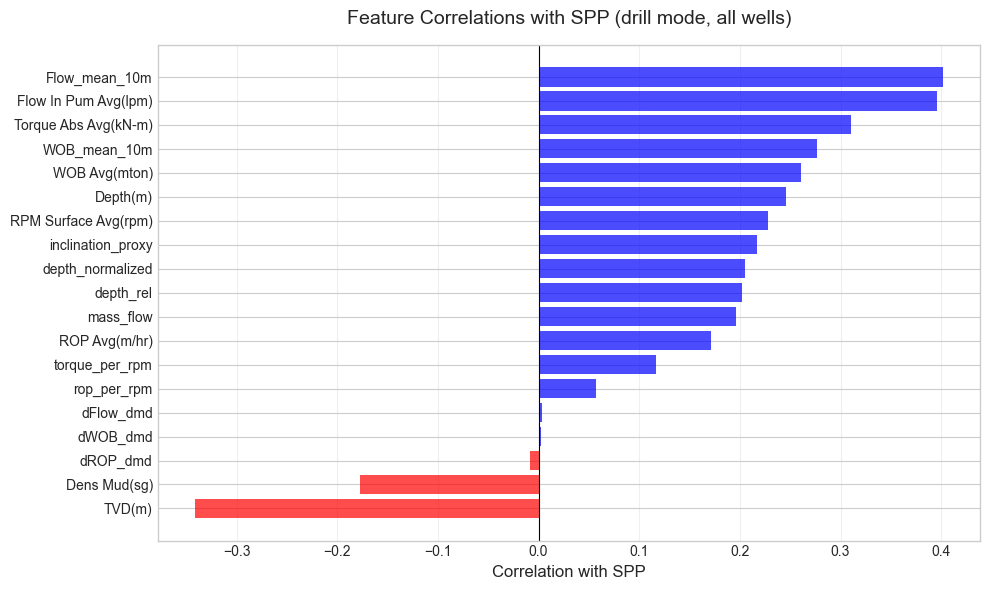


Correlations with ANNULAR (where available):
             feature  corr_with_ANNULAR
Torque Abs Avg(kN-m)           0.609873
            Depth(m)           0.580688
   inclination_proxy           0.563162
      torque_per_rpm           0.350511
           depth_rel           0.341837
    depth_normalized           0.237162
        Dens Mud(sg)          -0.208052
RPM Surface Avg(rpm)           0.182771
       ROP Avg(m/hr)           0.125138
        WOB_mean_10m           0.122662
       WOB Avg(mton)           0.116433
           mass_flow          -0.099690
Flow In Pum Avg(lpm)           0.031793
       Flow_mean_10m           0.029420
         rop_per_rpm           0.023108
            dWOB_dmd           0.005012
              TVD(m)          -0.004797
            dROP_dmd           0.002570
           dFlow_dmd           0.001333


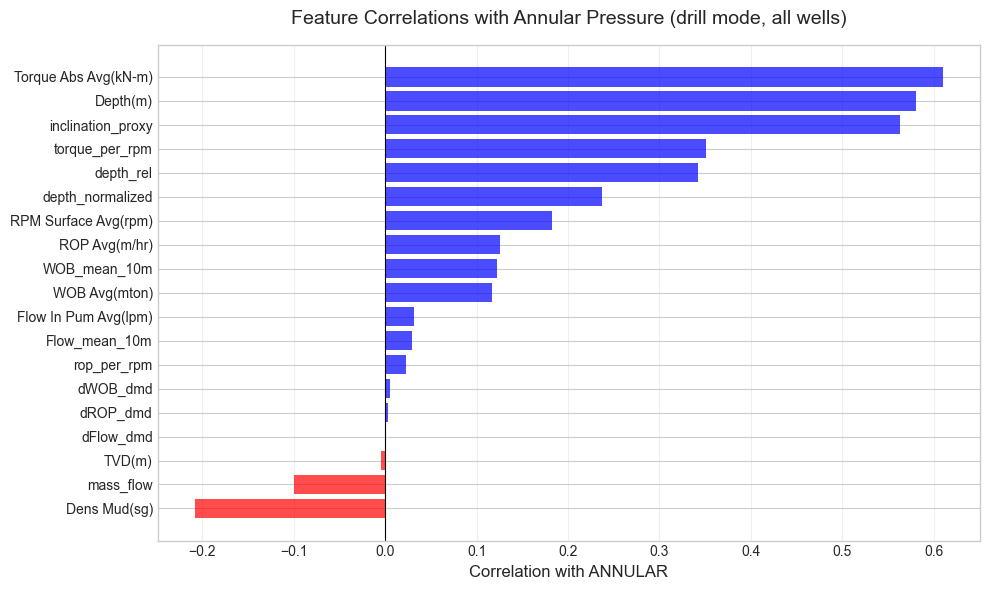

In [19]:
def compute_correlations(df, feature_cols, target_cols):
    """
    Compute correlation matrix between features and targets.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    feature_cols : list
        List of feature column names
    target_cols : list
        List of target column names
        
    Returns:
    --------
    corr_df : DataFrame
        Correlation matrix
    """
    cols_to_use = feature_cols + [col for col in target_cols if col in df.columns]
    df_subset = df[cols_to_use]
    return df_subset.corr()

# Compute overall correlations
target_cols = [SPP_COL, ANNULAR_COL]
corr_matrix = compute_correlations(df_drill, ALL_FEATURE_COLS, target_cols)

print("Full correlation matrix (features + targets):")
print(corr_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1, axis=None))

# Plot correlation matrix heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Mask upper triangle
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            mask=mask, ax=ax)
ax.set_title("Correlation Matrix: Features + Targets (drill mode, all wells)", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("../figures/FE/feature_correlations.pdf")
plt.show()

# Extract correlations with targets
print("\n" + "="*80)
print("Correlations with SPP:")
print("="*80)
spp_corrs = []
for feat in ALL_FEATURE_COLS:
    if feat in corr_matrix.index and SPP_COL in corr_matrix.columns:
        corr_val = corr_matrix.loc[feat, SPP_COL]
        spp_corrs.append({"feature": feat, "corr_with_SPP": corr_val})
spp_corr_df = pd.DataFrame(spp_corrs).sort_values("corr_with_SPP", key=abs, ascending=False)
print(spp_corr_df.to_string(index=False))

# Plot correlations with SPP
fig, ax = plt.subplots(figsize=(10, 6))
spp_corr_df_sorted = spp_corr_df.sort_values("corr_with_SPP", ascending=True)
colors = ['red' if x < 0 else 'blue' for x in spp_corr_df_sorted["corr_with_SPP"]]
ax.barh(spp_corr_df_sorted["feature"], spp_corr_df_sorted["corr_with_SPP"], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel("Correlation with SPP", fontsize=12)
ax.set_title("Feature Correlations with SPP (drill mode, all wells)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Correlations with ANNULAR (where available):")
print("="*80)
df_drill_ann = df_drill[df_drill[ANNULAR_COL].notna()]
if len(df_drill_ann) > 0:
    corr_matrix_ann = compute_correlations(df_drill_ann, ALL_FEATURE_COLS, [ANNULAR_COL])
    annular_corrs = []
    for feat in ALL_FEATURE_COLS:
        if feat in corr_matrix_ann.index and ANNULAR_COL in corr_matrix_ann.columns:
            corr_val = corr_matrix_ann.loc[feat, ANNULAR_COL]
            annular_corrs.append({"feature": feat, "corr_with_ANNULAR": corr_val})
    annular_corr_df = pd.DataFrame(annular_corrs).sort_values("corr_with_ANNULAR", key=abs, ascending=False)
    print(annular_corr_df.to_string(index=False))
    
    # Plot correlations with ANNULAR
    fig, ax = plt.subplots(figsize=(10, 6))
    annular_corr_df_sorted = annular_corr_df.sort_values("corr_with_ANNULAR", ascending=True)
    colors = ['red' if x < 0 else 'blue' for x in annular_corr_df_sorted["corr_with_ANNULAR"]]
    ax.barh(annular_corr_df_sorted["feature"], annular_corr_df_sorted["corr_with_ANNULAR"], color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel("Correlation with ANNULAR", fontsize=12)
    ax.set_title("Feature Correlations with Annular Pressure (drill mode, all wells)", fontsize=14, pad=15)
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("No annular pressure data available")


In [7]:
corr_matrix.to_csv("../data/tables/corr_matrix.csv")

Per-well correlations with SPP:


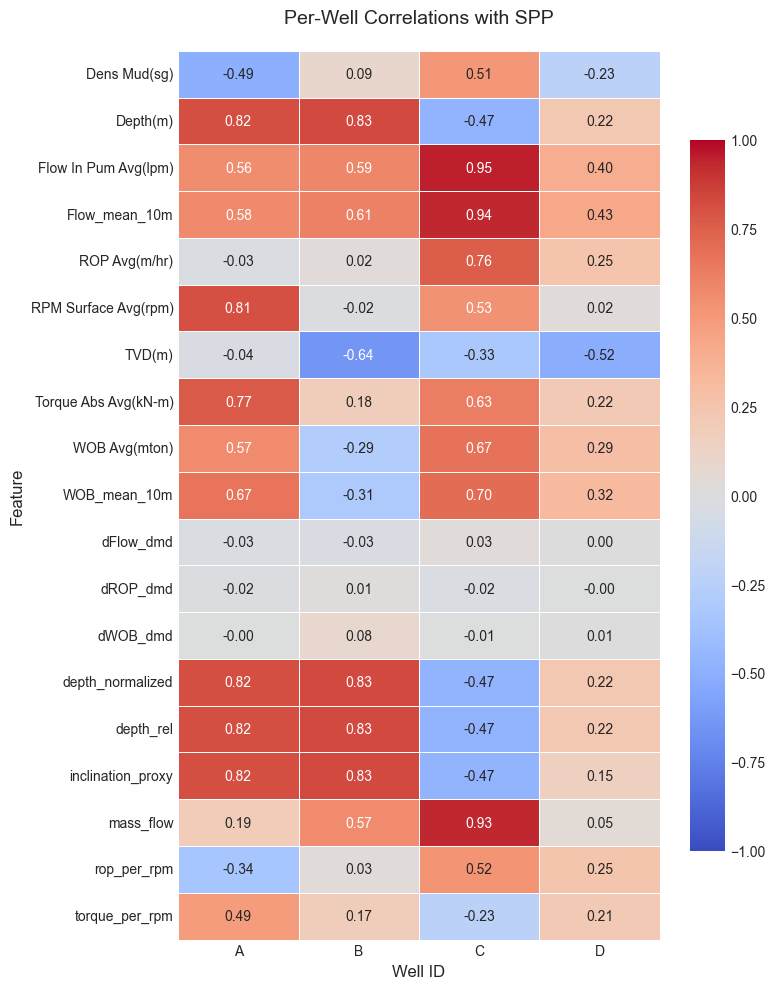


Per-well correlations with ANNULAR:


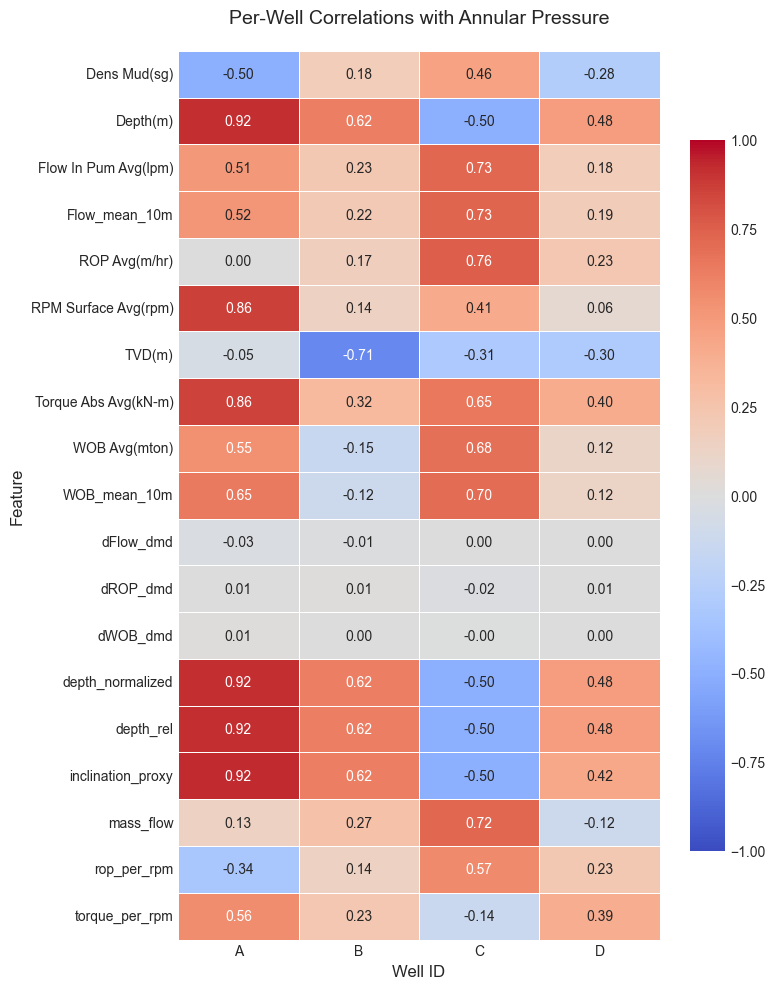

In [8]:
# Per-well correlations
per_well_corrs = []

for well_id, df_well in df_drill.groupby("well_id"):
    # SPP correlations
    corr_matrix_well = compute_correlations(df_well, ALL_FEATURE_COLS, [SPP_COL])
    for feat in ALL_FEATURE_COLS:
        if feat in corr_matrix_well.index and SPP_COL in corr_matrix_well.columns:
            corr_spp = corr_matrix_well.loc[feat, SPP_COL]
            per_well_corrs.append({
                "well_id": well_id,
                "feature": feat,
                "corr_with_SPP": corr_spp,
                "corr_with_ANNULAR": np.nan
            })
    
    # Annular correlations (if available)
    df_well_ann = df_well[df_well[ANNULAR_COL].notna()]
    if len(df_well_ann) > 0:
        corr_matrix_ann_well = compute_correlations(df_well_ann, ALL_FEATURE_COLS, [ANNULAR_COL])
        for feat in ALL_FEATURE_COLS:
            if feat in corr_matrix_ann_well.index and ANNULAR_COL in corr_matrix_ann_well.columns:
                corr_ann = corr_matrix_ann_well.loc[feat, ANNULAR_COL]
                # Update existing row or create new
                idx = next((i for i, row in enumerate(per_well_corrs) 
                           if row["well_id"] == well_id and row["feature"] == feat), None)
                if idx is not None:
                    per_well_corrs[idx]["corr_with_ANNULAR"] = corr_ann

per_well_corr_df = pd.DataFrame(per_well_corrs)

print("Per-well correlations with SPP:")
print("="*80)
pivot_spp = per_well_corr_df.pivot(index="feature", columns="well_id", values="corr_with_SPP")
print(pivot_spp.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1, axis=None))

# Plot per-well SPP correlations heatmap
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(pivot_spp, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=False, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Per-Well Correlations with SPP", fontsize=14, pad=20)
ax.set_xlabel("Well ID", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

if per_well_corr_df["corr_with_ANNULAR"].notna().any():
    print("\nPer-well correlations with ANNULAR:")
    print("="*80)
    pivot_ann = per_well_corr_df.pivot(index="feature", columns="well_id", values="corr_with_ANNULAR")
    print(pivot_ann.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1, axis=None))
    
    # Plot per-well ANNULAR correlations heatmap
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(pivot_ann, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                vmin=-1, vmax=1, square=False, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title("Per-Well Correlations with Annular Pressure", fontsize=14, pad=20)
    ax.set_xlabel("Well ID", fontsize=12)
    ax.set_ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()


In [9]:
per_well_corr_df.to_csv("../data/tables/per_well_corr_df.csv", index=False)

In [10]:
# Missingness analysis per well
missingness_summary = []

for well_id, df_well in df_drill.groupby("well_id"):
    n_samples = len(df_well)
    for feat in BASE_FEATURE_CANDIDATES:
        n_nans = df_well[feat].isna().sum()
        frac_nans = n_nans / n_samples if n_samples > 0 else 0.0
        missingness_summary.append({
            "well_id": well_id,
            "feature": feat,
            "n_samples": n_samples,
            "n_nans": n_nans,
            "frac_nans": frac_nans
        })

missingness_df = pd.DataFrame(missingness_summary)

print("Missingness summary per well:")
print("="*80)
pivot_missing = missingness_df.pivot(index="feature", columns="well_id", values="frac_nans")
print(pivot_missing)

print("\nOverall missingness (all wells combined):")
print("="*80)
overall_missing = df_drill[BASE_FEATURE_CANDIDATES].isna().sum() / len(df_drill)
overall_missing_df = pd.DataFrame({
    "feature": overall_missing.index,
    "frac_nans": overall_missing.values
}).sort_values("frac_nans", ascending=False)
print(overall_missing_df.to_string(index=False))


Missingness summary per well:
well_id                      A         B    C         D
feature                                                
Dens Mud(sg)          0.028446  0.001912  0.0  0.000000
Depth(m)              0.000000  0.000000  0.0  0.000000
Flow In Pum Avg(lpm)  0.000000  0.000000  0.0  0.000000
ROP Avg(m/hr)         0.000000  0.000000  0.0  0.000242
RPM Surface Avg(rpm)  0.000000  0.000000  0.0  0.000000
TVD(m)                0.000000  0.000000  0.0  0.082043
Torque Abs Avg(kN-m)  0.000000  0.000000  0.0  0.000000
WOB Avg(mton)         0.000000  0.000000  0.0  0.000000

Overall missingness (all wells combined):
             feature  frac_nans
              TVD(m)   0.038034
        Dens Mud(sg)   0.008078
       ROP Avg(m/hr)   0.000112
            Depth(m)   0.000000
Flow In Pum Avg(lpm)   0.000000
Torque Abs Avg(kN-m)   0.000000
       WOB Avg(mton)   0.000000
RPM Surface Avg(rpm)   0.000000


Generating plots: SPP vs candidate features...


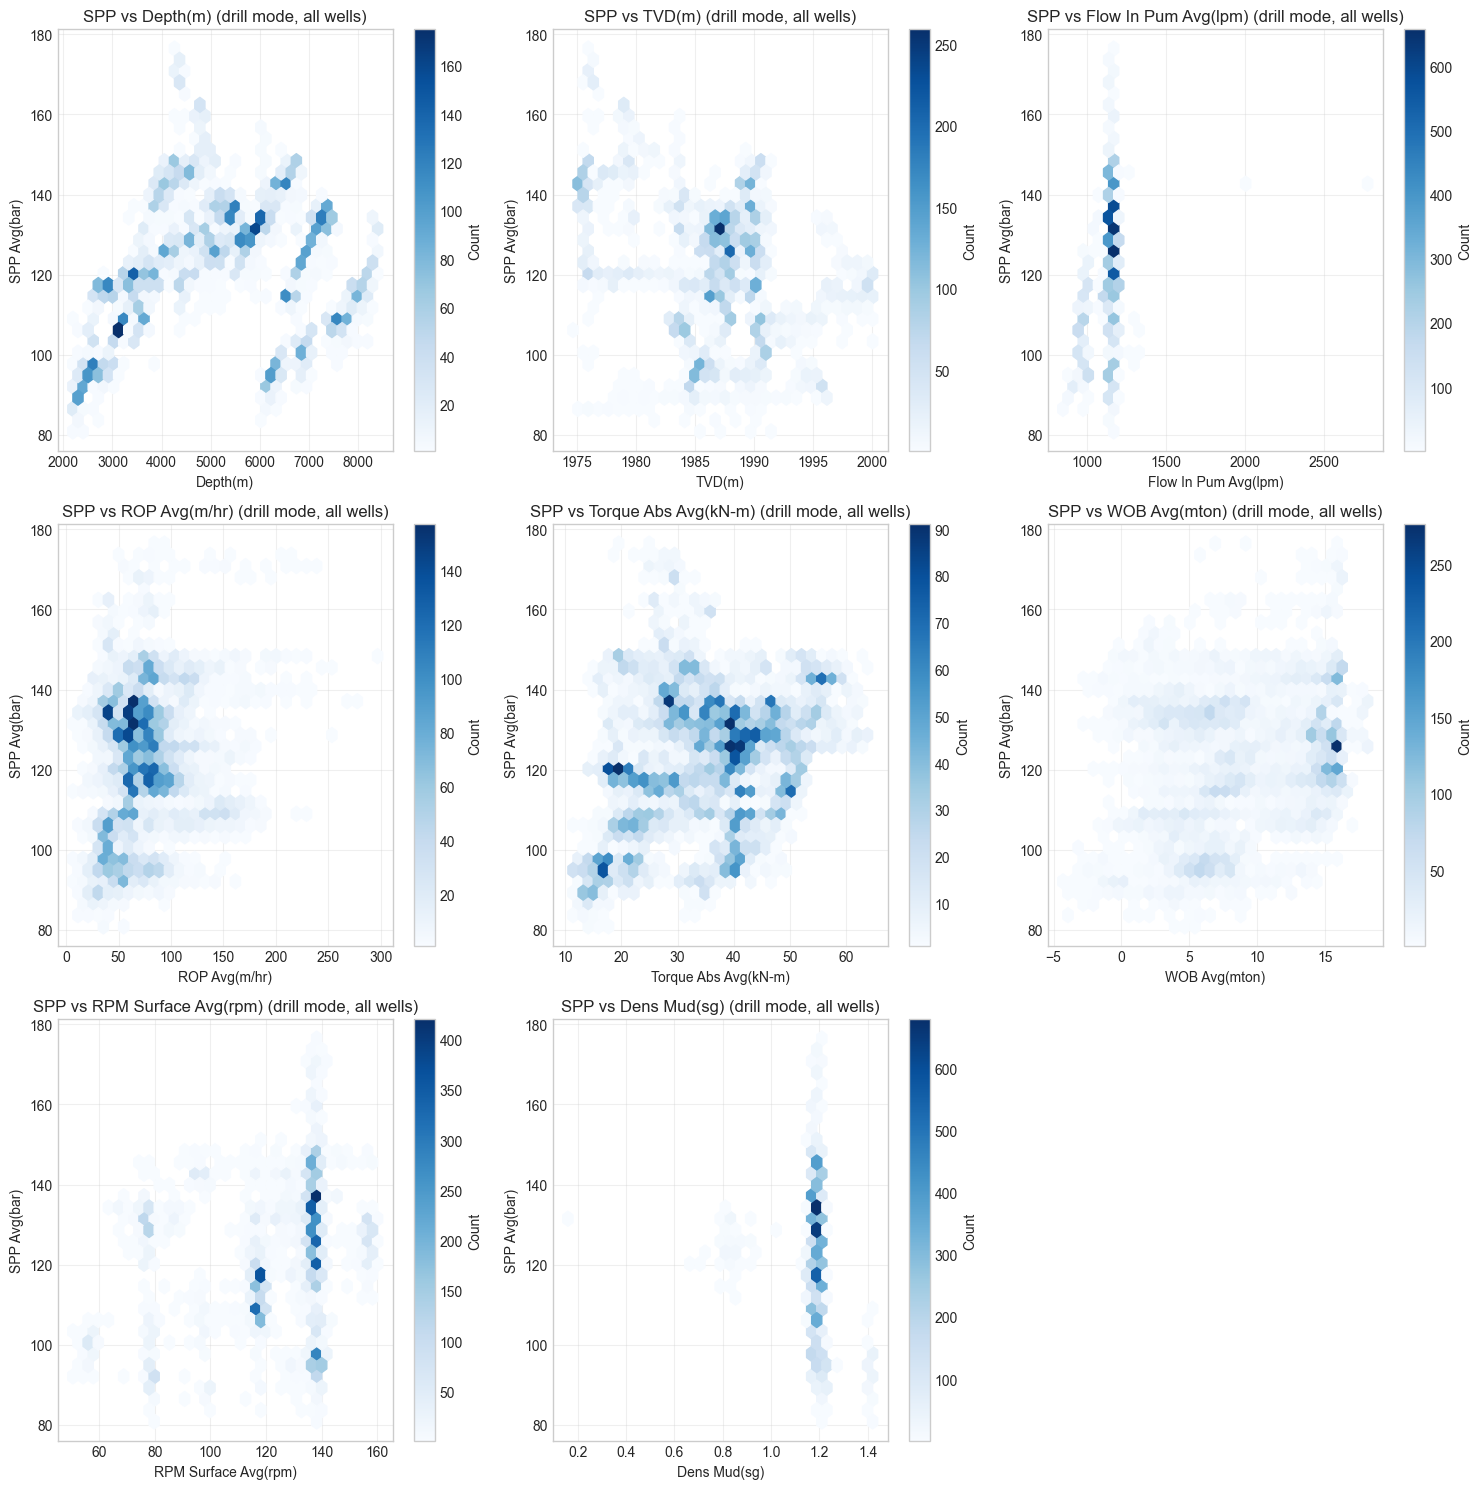

In [11]:
def plot_feature_vs_target(df, feature_col, target_col, color_by=None, 
                           title=None, ax=None, use_hexbin=True):
    """
    Plot feature vs target, optionally colored by a categorical variable.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    feature_col : str
        Feature column name
    target_col : str
        Target column name
    color_by : str, optional
        Column name to color points by (e.g., "well_id")
    title : str, optional
        Plot title
    ax : matplotlib.axes.Axes, optional
        Axes to plot on
    use_hexbin : bool
        If True, use hexbin for dense data; otherwise use scatter
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Filter to valid data
    mask = df[feature_col].notna() & df[target_col].notna()
    if color_by:
        mask = mask & df[color_by].notna()
    df_plot = df[mask]
    
    if len(df_plot) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        return ax
    
    if color_by and color_by in df_plot.columns:
        # Color by categorical variable
        unique_vals = df_plot[color_by].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_vals)))
        for val, color in zip(unique_vals, colors):
            mask_val = df_plot[color_by] == val
            ax.scatter(df_plot.loc[mask_val, feature_col], 
                      df_plot.loc[mask_val, target_col],
                      alpha=0.5, s=20, label=str(val), color=color)
        ax.legend(title=color_by)
    else:
        # Single color
        if use_hexbin and len(df_plot) > 1000:
            hb = ax.hexbin(df_plot[feature_col], df_plot[target_col], 
                          gridsize=30, cmap='Blues', mincnt=1)
            plt.colorbar(hb, ax=ax, label='Count')
        else:
            ax.scatter(df_plot[feature_col], df_plot[target_col], 
                      alpha=0.3, s=10)
    
    ax.set_xlabel(feature_col)
    ax.set_ylabel(target_col)
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot SPP vs each candidate feature
print("Generating plots: SPP vs candidate features...")

n_features = len(BASE_FEATURE_CANDIDATES)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feat in enumerate(BASE_FEATURE_CANDIDATES):
    plot_feature_vs_target(df_drill, feat, SPP_COL, 
                          title=f"SPP vs {feat} (drill mode, all wells)",
                          ax=axes[idx], use_hexbin=True)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


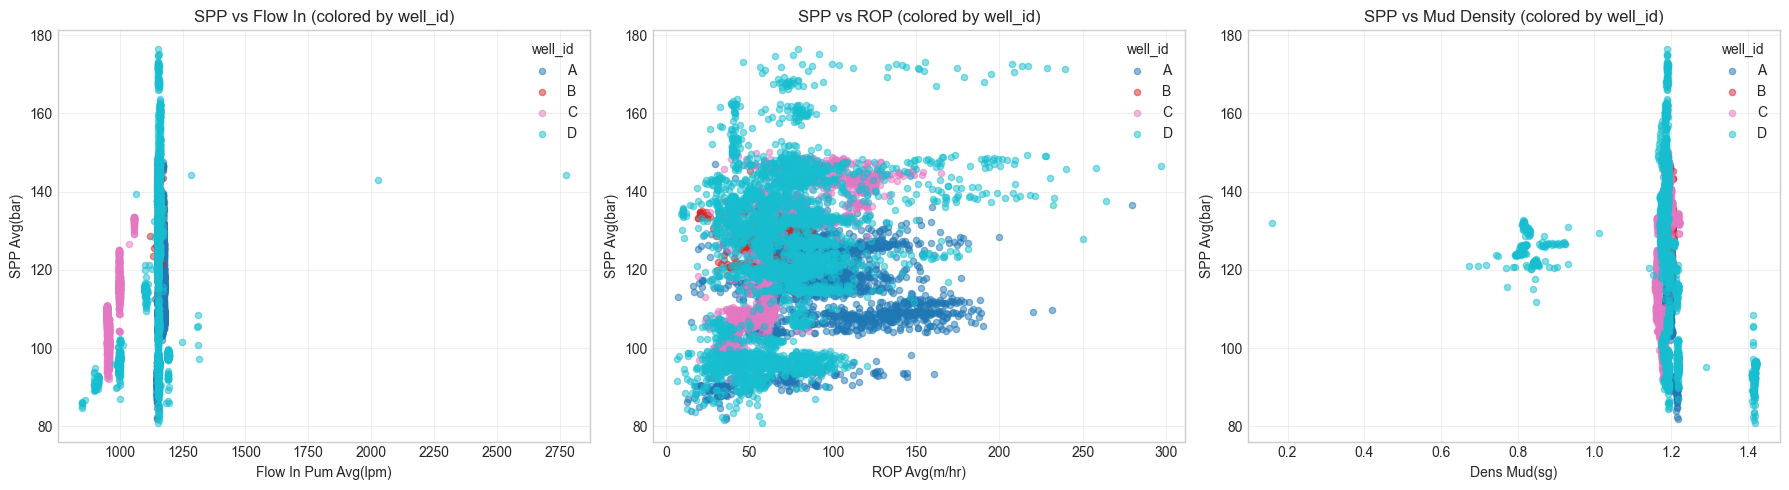

In [12]:
# Key plots with color by well_id
key_pairs = [
    (FLOW_COL, "Flow In"),
    (ROP_COL, "ROP"),
    (MUD_DENSITY_COL, "Mud Density")
]

fig, axes = plt.subplots(1, len(key_pairs), figsize=(6*len(key_pairs), 5))
if len(key_pairs) == 1:
    axes = [axes]

for ax, (feat_col, feat_label) in zip(axes, key_pairs):
    plot_feature_vs_target(df_drill, feat_col, SPP_COL, 
                          color_by="well_id",
                          title=f"SPP vs {feat_label} (colored by well_id)",
                          ax=ax, use_hexbin=False)

plt.tight_layout()
plt.show()


Annular pressure plots: 8913 samples available


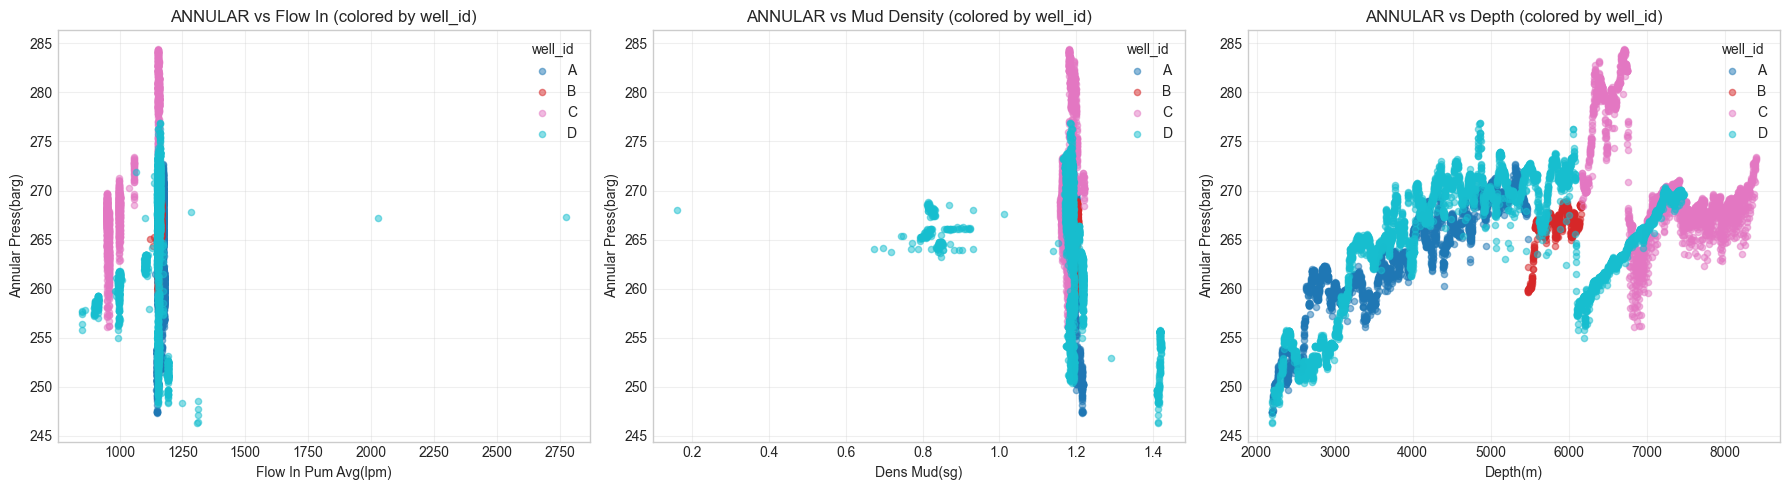

In [13]:
# Plots for annular pressure (where available)
df_drill_ann = df_drill[df_drill[ANNULAR_COL].notna()].copy()

if len(df_drill_ann) > 0:
    print(f"Annular pressure plots: {len(df_drill_ann)} samples available")
    
    key_pairs_ann = [
        (FLOW_COL, "Flow In"),
        (MUD_DENSITY_COL, "Mud Density"),
        (DEPTH_COL, "Depth")
    ]
    
    fig, axes = plt.subplots(1, len(key_pairs_ann), figsize=(6*len(key_pairs_ann), 5))
    if len(key_pairs_ann) == 1:
        axes = [axes]
    
    for ax, (feat_col, feat_label) in zip(axes, key_pairs_ann):
        plot_feature_vs_target(df_drill_ann, feat_col, ANNULAR_COL,
                              color_by="well_id",
                              title=f"ANNULAR vs {feat_label} (colored by well_id)",
                              ax=ax, use_hexbin=False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No annular pressure data available for plotting")


In [14]:
# Simple feature engineering diagnostics (already computed earlier)
print("Engineered features present:")
print(ENGINEERED_FEATURES)

feature_stats = df_drill[ENGINEERED_FEATURES].describe().T
print("\nEngineered feature statistics (all wells, drill mode):")
print(feature_stats)



Engineered features present:
['mass_flow', 'depth_normalized', 'depth_rel', 'inclination_proxy', 'dWOB_dmd', 'dFlow_dmd', 'dROP_dmd', 'WOB_mean_10m', 'Flow_mean_10m', 'torque_per_rpm', 'rop_per_rpm']

Engineered feature statistics (all wells, drill mode):
                    count         mean          std          min          25%  \
mass_flow          8841.0  1342.319353   112.472156   183.217492  1361.962780   
depth_normalized   8913.0  1950.317065  1407.933472     0.000000   745.000000   
depth_rel          8913.0     0.504038     0.286418     0.000000     0.254408   
inclination_proxy  8574.0  3173.876312  1660.402188   220.793900  1747.163250   
dWOB_dmd           8909.0     0.001813     1.362579   -13.538800    -0.267700   
dFlow_dmd          8909.0    -0.026814    20.627057 -1492.759300    -0.123300   
dROP_dmd           8907.0     0.011462    17.254248  -182.461700    -4.667700   
WOB_mean_10m       8913.0     9.426542     4.754403    -3.158340     5.627570   
Flow_mean_10m  

In [15]:
# Correlations for engineered features
print("Correlations of engineered features with SPP and ANNULAR:")
print("="*80)

eng_corrs = []
for feat in ENGINEERED_FEATURES:
    if feat in df_drill.columns:
        # SPP correlation
        corr_spp = df_drill[[feat, SPP_COL]].corr().loc[feat, SPP_COL]
        corr_ann = np.nan
        if df_drill[ANNULAR_COL].notna().sum() > 0:
            corr_ann = df_drill[[feat, ANNULAR_COL]].corr().loc[feat, ANNULAR_COL]
        eng_corrs.append({
            "feature": feat,
            "corr_with_SPP": corr_spp,
            "corr_with_ANNULAR": corr_ann
        })

eng_corr_df = pd.DataFrame(eng_corrs)
print(eng_corr_df.to_string(index=False))

# Compare mass_flow vs FLOW alone
print("\n" + "="*80)
print("Comparison: mass_flow vs FLOW correlations with SPP")
print("="*80)
flow_corr = df_drill[[FLOW_COL, SPP_COL]].corr().loc[FLOW_COL, SPP_COL]
mass_flow_corr = df_drill[["mass_flow", SPP_COL]].corr().loc["mass_flow", SPP_COL]
print(f"{FLOW_COL} correlation with SPP: {flow_corr:.4f}")
print(f"mass_flow correlation with SPP: {mass_flow_corr:.4f}")
print(f"Difference: {abs(mass_flow_corr) - abs(flow_corr):.4f}")


Correlations of engineered features with SPP and ANNULAR:
          feature  corr_with_SPP  corr_with_ANNULAR
        mass_flow       0.196467          -0.099690
 depth_normalized       0.204731           0.237162
        depth_rel       0.202156           0.341837
inclination_proxy       0.217421           0.563162
         dWOB_dmd       0.002902           0.005012
        dFlow_dmd       0.003318           0.001333
         dROP_dmd      -0.008107           0.002570
     WOB_mean_10m       0.276579           0.122662
    Flow_mean_10m       0.401417           0.029420
   torque_per_rpm       0.116947           0.350511
      rop_per_rpm       0.057431           0.023108

Comparison: mass_flow vs FLOW correlations with SPP
Flow In Pum Avg(lpm) correlation with SPP: 0.3957
mass_flow correlation with SPP: 0.1965
Difference: -0.1992


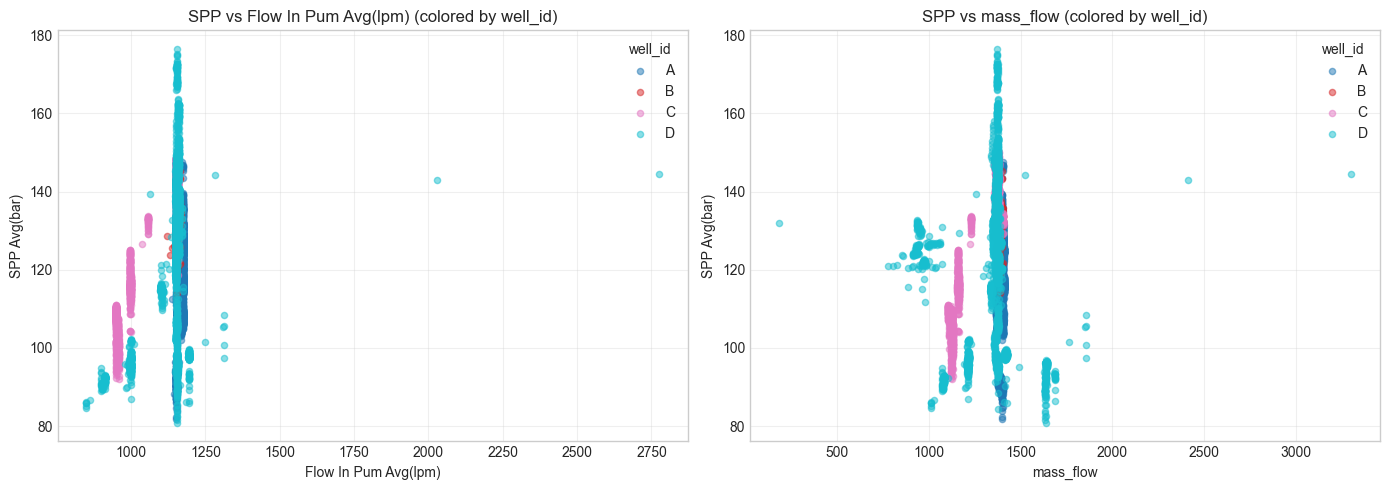

In [16]:
# Plot mass_flow vs SPP
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_feature_vs_target(df_drill, FLOW_COL, SPP_COL,
                      color_by="well_id",
                      title=f"SPP vs {FLOW_COL} (colored by well_id)",
                      ax=axes[0], use_hexbin=False)

plot_feature_vs_target(df_drill, "mass_flow", SPP_COL,
                      color_by="well_id",
                      title="SPP vs mass_flow (colored by well_id)",
                      ax=axes[1], use_hexbin=False)

plt.tight_layout()
plt.show()


In [17]:
# Summary and candidate base feature set
print("="*80)
print("FEATURE ANALYSIS SUMMARY")
print("="*80)

print("\n1. Correlation strength with SPP (overall):")
print(spp_corr_df.to_string(index=False))

# Check if annular correlations were computed (from cell 5)
try:
    if len(annular_corr_df) > 0:
        print("\n2. Correlation strength with ANNULAR (overall):")
        print(annular_corr_df.to_string(index=False))
except NameError:
    print("\n2. Correlation strength with ANNULAR: Not available (no annular data)")

print("\n3. Missingness (overall):")
print(overall_missing_df.to_string(index=False))

print("\n4. Engineered features:")
print(eng_corr_df.to_string(index=False))

print("\n" + "="*80)
print("PROPOSED BASE FEATURE SET")
print("="*80)
print("\nBased on:")
print("- Correlation strength with SPP and ANNULAR")
print("- Missing-data statistics")
print("- Physical meaning of variables")
print("- Stability across wells")

BASE_FEATURES = [
    "Depth(m)",
    "TVD(m)",
    "Flow In Pum Avg(lpm)",
    "ROP Avg(m/hr)",
    "Torque Abs Avg(kN-m)",
    "WOB Avg(mton)",
    "RPM Surface Avg(rpm)",
    "Dens Mud(sg)",
]


EXTENDED_ENGINEERED_FEATURES = [
    "inclination_proxy",  # geometry / hole inclination
    "mass_flow",          # Flow * rho
    "torque_per_rpm",     # especially for annular pressure
]


print(f"\nBASE_FEATURES = {BASE_FEATURES}")
print(f"\nEXTENDED_ENGINEERED_FEATURES (available for testing) = {EXTENDED_ENGINEERED_FEATURES}")

print("\nNote: This is a candidate set. Final feature selection should be")
print("validated through model performance and domain expertise.")


FEATURE ANALYSIS SUMMARY

1. Correlation strength with SPP (overall):
             feature  corr_with_SPP
       Flow_mean_10m       0.401417
Flow In Pum Avg(lpm)       0.395710
              TVD(m)      -0.341258
Torque Abs Avg(kN-m)       0.310259
        WOB_mean_10m       0.276579
       WOB Avg(mton)       0.260581
            Depth(m)       0.245531
RPM Surface Avg(rpm)       0.227826
   inclination_proxy       0.217421
    depth_normalized       0.204731
           depth_rel       0.202156
           mass_flow       0.196467
        Dens Mud(sg)      -0.177057
       ROP Avg(m/hr)       0.171205
      torque_per_rpm       0.116947
         rop_per_rpm       0.057431
            dROP_dmd      -0.008107
           dFlow_dmd       0.003318
            dWOB_dmd       0.002902

2. Correlation strength with ANNULAR (overall):
             feature  corr_with_ANNULAR
Torque Abs Avg(kN-m)           0.609873
            Depth(m)           0.580688
   inclination_proxy           0.563162
 